In [1]:
#PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

#Numpy
import numpy as np

#Dataset
import torch.utils.data as utils

#Graphs
import matplotlib.pyplot as plt

#For paths
import sys
import os
import glob

#imread and resize
from skimage import io, transform

#split dataset
from sklearn.model_selection import train_test_split

#Timestamp
import datetime

#PyTorch Models
path = os.path.join(os.path.dirname(os.path.abspath('__file__')), "models")
sys.path.append(path)
from models import *

In [2]:
root_path = os.path.join(os.path.dirname(os.path.abspath('__file__')), "kinect_leap_dataset", "acquisitions")
p_id = ["P1", "P2", "P3", "P4", "P5", "P6", "P7", "P8", "P9", "P10", "P11", "P12", "P13", "P14"]
g_id = ["G1", "G2", "G3", "G4", "G5", "G6", "G7", "G8", "G9", "G10"]

In [3]:
files = glob.glob(os.path.join(root_path, "P1", "G1", "*rgb.png"))

In [4]:
dataset = []
labels = []

for p in p_id:
    for g in g_id:
        path = os.path.join(root_path, p, g)
        image_names = glob.glob(os.path.join(path, "*rgb.png"))
        for img_path in image_names:
            img = io.imread(img_path)
            
            #img = transform.rescale(img, 1.0 / 20.0)
            img = transform.resize(img, (32, 32))
            #48x64x3 -> 3x48x64
            img = np.moveaxis(img, [0, 1, 2], [1, 2, 0])
            
            dataset.append(img)
            
            #label 10 will be 0
            tmp = np.zeros(10)
            tmp[int(g[-1])] = 1
            labels.append(tmp)
            #labels.append(int(g[-1]))

C:\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [5]:
dataset = np.array(dataset).astype(float)
labels = np.array(labels).astype(float)

In [6]:
X_train, X_test_val, y_train, y_test_val = train_test_split(dataset, labels, test_size=0.2)
X_val, X_test, y_val, y_test = train_test_split(X_test_val, y_test_val, test_size=0.5)

In [7]:
dataset = torch.from_numpy(dataset).float()
labels = torch.from_numpy(labels).float()

In [8]:
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()
X_val = torch.from_numpy(X_val).float()
y_val = torch.from_numpy(y_val).float()

In [9]:
my_dataset = utils.TensorDataset(dataset, labels) # create your dataset
my_dataloader = utils.DataLoader(my_dataset, batch_size=10, shuffle=True, num_workers=4) # create your dataloader

In [10]:
my_dataset = utils.TensorDataset(X_train, y_train) # create your dataset
train_loader = utils.DataLoader(my_dataset, batch_size=10, shuffle=True, num_workers=4) # create your dataloader

my_dataset = utils.TensorDataset(X_val, y_val) # create your dataset
val_loader = utils.DataLoader(my_dataset, batch_size=10, shuffle=True, num_workers=4) # create your dataloader

my_dataset = utils.TensorDataset(X_test, y_test) # create your dataset
test_loader = utils.DataLoader(my_dataset, batch_size=10, shuffle=True, num_workers=4) # create your dataloader

In [11]:
model = VGG('VGG16')
#Target has to be LongSensor for CrossEntropyLoss
criterion = nn.CrossEntropyLoss()

#criterion = torch.nn.MSELoss(size_average=False)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6, betas=(0.9, 0.999), eps=1e-8, weight_decay=5e-4)

#optimizer = optim.SGD(resnet.parameters(), lr=args.lr, momentum=0.9, weight_decay=5e-4)

In [12]:
def test():
    net = VGG('VGG16')
    x = torch.randn(2,3,32,32)
    y = net(x)
    print(y.size())
test()

torch.Size([2, 10])


In [13]:
train_loss_history = []
train_acc_history = []
val_acc_history = []
val_loss_history = []
num_epochs = 200
iter_per_epoch = len(train_loader)
#224 lines -> 112 val output for log_nth=10000
#1120000 iter
log_nth = 100

if torch.cuda.is_available():
    model.cuda()

for epoch in range(num_epochs):  # loop over the dataset multiple times
    for i, (inputs, targets) in enumerate(train_loader, 1):
        #inputs, targets = Variable(inputs.float()), Variable(targets.float())
        #for CrossEntropyLoss
        inputs, targets = Variable(inputs), Variable(targets)
        if torch.cuda.is_available():
            inputs, targets = inputs.cuda(), targets.cuda()
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        
        #loss = criterion(outputs, targets)
        #for CrossEntropyLoss
        loss = criterion(outputs, torch.max(targets, 1)[1])
        
        loss.backward()
        optimizer.step()

        # print statistics
        train_loss_history.append(loss.data.cpu().numpy())
        if log_nth and i % log_nth == 0:
            last_log_nth_losses = train_loss_history[-log_nth:]
            train_loss = np.mean(last_log_nth_losses)
            print('[Iteration %d/%d] TRAIN loss: %.3f' % \
                        (i + epoch * iter_per_epoch,
                         iter_per_epoch * num_epochs,
                         train_loss))
            
    _, preds = torch.max(outputs, 1)
    _, target_indices = torch.max(targets, 1)

    train_acc = np.mean((preds == target_indices).data.cpu().numpy())
    train_acc_history.append(train_acc)
    if log_nth:
        print('[Epoch %d/%d] TRAIN acc/loss: %.3f/%.3f' % (epoch + 1,
                                                            num_epochs,
                                                            train_acc,
                                                            loss))
        '''_, preds = torch.max(outputs, 1)

        # Only allow images/pixels with label >= 0 e.g. for segmentation
        targets_mask = labels >= 0
        train_acc = np.mean((preds == targets)[targets_mask].data.cpu().numpy())
        train_acc_history.append(train_acc)
        if log_nth:
            print('[Epoch %d/%d] TRAIN acc/loss: %.3f/%.3f' % (epoch + 1,
                                                                   num_epochs,
                                                                   train_acc,
                                                                   train_loss))'''
        
    # VALIDATION
    val_losses = []
    val_scores = []
    model.eval()
    for inputs, targets in val_loader:
        inputs, targets = Variable(inputs), Variable(targets)
        if torch.cuda.is_available():
            inputs, targets = inputs.cuda(), targets.cuda()

        outputs = model.forward(inputs)
        
        #loss = criterion(outputs, targets)
        
        #for CrossEntropyLoss
        loss = criterion(outputs, torch.max(targets, 1)[1])
        
        val_losses.append(loss.data.cpu().numpy())

        _, preds = torch.max(outputs, 1)
        _, target_indices = torch.max(targets, 1)

        scores = np.mean((preds == target_indices).data.cpu().numpy())
        val_scores.append(scores)

    model.train()
    val_acc, val_loss = np.mean(val_scores), np.mean(val_losses)
    val_acc_history.append(val_acc)
    val_loss_history.append(val_loss)
    if log_nth:
        print('[Epoch %d/%d] VAL   acc/loss: %.3f/%.3f' % (epoch + 1,
                                                            num_epochs,
                                                            val_acc,
                                                            val_loss))

print('Finished Training')

[Iteration 100/22400] TRAIN loss: 2.369
[Epoch 1/200] TRAIN acc/loss: 0.000/2.379
[Epoch 1/200] VAL   acc/loss: 0.086/2.367
[Iteration 212/22400] TRAIN loss: 2.299
[Epoch 2/200] TRAIN acc/loss: 0.100/2.148
[Epoch 2/200] VAL   acc/loss: 0.086/2.326
[Iteration 324/22400] TRAIN loss: 2.231
[Epoch 3/200] TRAIN acc/loss: 0.100/2.198
[Epoch 3/200] VAL   acc/loss: 0.107/2.308
[Iteration 436/22400] TRAIN loss: 2.190
[Epoch 4/200] TRAIN acc/loss: 0.100/2.194
[Epoch 4/200] VAL   acc/loss: 0.129/2.270
[Iteration 548/22400] TRAIN loss: 2.137
[Epoch 5/200] TRAIN acc/loss: 0.100/2.297
[Epoch 5/200] VAL   acc/loss: 0.150/2.243
[Iteration 660/22400] TRAIN loss: 2.085
[Epoch 6/200] TRAIN acc/loss: 0.300/2.039
[Epoch 6/200] VAL   acc/loss: 0.179/2.220
[Iteration 772/22400] TRAIN loss: 2.035
[Epoch 7/200] TRAIN acc/loss: 0.400/2.091
[Epoch 7/200] VAL   acc/loss: 0.193/2.191
[Iteration 884/22400] TRAIN loss: 1.990
[Epoch 8/200] TRAIN acc/loss: 0.400/1.983
[Epoch 8/200] VAL   acc/loss: 0.200/2.164
[Iterati

[Iteration 7380/22400] TRAIN loss: 0.168
[Epoch 66/200] TRAIN acc/loss: 1.000/0.174
[Epoch 66/200] VAL   acc/loss: 0.721/0.929
[Iteration 7492/22400] TRAIN loss: 0.161
[Epoch 67/200] TRAIN acc/loss: 1.000/0.092
[Epoch 67/200] VAL   acc/loss: 0.729/0.909
[Iteration 7604/22400] TRAIN loss: 0.162
[Epoch 68/200] TRAIN acc/loss: 1.000/0.145
[Epoch 68/200] VAL   acc/loss: 0.736/0.931
[Iteration 7716/22400] TRAIN loss: 0.148
[Epoch 69/200] TRAIN acc/loss: 1.000/0.187
[Epoch 69/200] VAL   acc/loss: 0.707/0.887
[Iteration 7828/22400] TRAIN loss: 0.136
[Epoch 70/200] TRAIN acc/loss: 1.000/0.168
[Epoch 70/200] VAL   acc/loss: 0.743/0.898
[Iteration 7940/22400] TRAIN loss: 0.139
[Epoch 71/200] TRAIN acc/loss: 1.000/0.109
[Epoch 71/200] VAL   acc/loss: 0.721/0.867
[Iteration 8052/22400] TRAIN loss: 0.132
[Epoch 72/200] TRAIN acc/loss: 1.000/0.115
[Epoch 72/200] VAL   acc/loss: 0.757/0.870
[Iteration 8164/22400] TRAIN loss: 0.109
[Epoch 73/200] TRAIN acc/loss: 1.000/0.059
[Epoch 73/200] VAL   acc/lo

[Iteration 14548/22400] TRAIN loss: 0.015
[Epoch 130/200] TRAIN acc/loss: 1.000/0.015
[Epoch 130/200] VAL   acc/loss: 0.786/0.665
[Iteration 14660/22400] TRAIN loss: 0.016
[Epoch 131/200] TRAIN acc/loss: 1.000/0.010
[Epoch 131/200] VAL   acc/loss: 0.779/0.641
[Iteration 14772/22400] TRAIN loss: 0.013
[Epoch 132/200] TRAIN acc/loss: 1.000/0.017
[Epoch 132/200] VAL   acc/loss: 0.786/0.645
[Iteration 14884/22400] TRAIN loss: 0.013
[Epoch 133/200] TRAIN acc/loss: 1.000/0.006
[Epoch 133/200] VAL   acc/loss: 0.793/0.626
[Iteration 14996/22400] TRAIN loss: 0.012
[Epoch 134/200] TRAIN acc/loss: 1.000/0.010
[Epoch 134/200] VAL   acc/loss: 0.793/0.650
[Iteration 15108/22400] TRAIN loss: 0.014
[Epoch 135/200] TRAIN acc/loss: 1.000/0.008
[Epoch 135/200] VAL   acc/loss: 0.793/0.651
[Iteration 15220/22400] TRAIN loss: 0.013
[Epoch 136/200] TRAIN acc/loss: 1.000/0.010
[Epoch 136/200] VAL   acc/loss: 0.779/0.671
[Iteration 15332/22400] TRAIN loss: 0.011
[Epoch 137/200] TRAIN acc/loss: 1.000/0.011
[Epo

[Epoch 193/200] TRAIN acc/loss: 1.000/0.004
[Epoch 193/200] VAL   acc/loss: 0.821/0.585
[Iteration 21716/22400] TRAIN loss: 0.007
[Epoch 194/200] TRAIN acc/loss: 1.000/0.004
[Epoch 194/200] VAL   acc/loss: 0.800/0.623
[Iteration 21828/22400] TRAIN loss: 0.005
[Epoch 195/200] TRAIN acc/loss: 1.000/0.017
[Epoch 195/200] VAL   acc/loss: 0.814/0.594
[Iteration 21940/22400] TRAIN loss: 0.005
[Epoch 196/200] TRAIN acc/loss: 1.000/0.006
[Epoch 196/200] VAL   acc/loss: 0.814/0.627
[Iteration 22052/22400] TRAIN loss: 0.005
[Epoch 197/200] TRAIN acc/loss: 1.000/0.002
[Epoch 197/200] VAL   acc/loss: 0.807/0.613
[Iteration 22164/22400] TRAIN loss: 0.003
[Epoch 198/200] TRAIN acc/loss: 1.000/0.004
[Epoch 198/200] VAL   acc/loss: 0.800/0.606
[Iteration 22276/22400] TRAIN loss: 0.005
[Epoch 199/200] TRAIN acc/loss: 1.000/0.003
[Epoch 199/200] VAL   acc/loss: 0.836/0.609
[Iteration 22388/22400] TRAIN loss: 0.005
[Epoch 200/200] TRAIN acc/loss: 1.000/0.002
[Epoch 200/200] VAL   acc/loss: 0.800/0.602
Fi

In [14]:
params = list(model.parameters())

In [15]:
#https://pytorch.org/docs/stable/notes/serialization.html#recommend-saving-models
currentDT = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
path = os.path.join(os.path.dirname(os.path.abspath('__file__')), "saved_models", "vgg_rgb_" + str(num_epochs) + "_" + currentDT + ".model")
torch.save(model.state_dict(), path)

#Loading
#model = VGG('VGG16')
#model.load_state_dict(torch.load(path))

In [16]:
scores = []
for inputs, target in test_loader:
    inputs, targets = Variable(inputs), Variable(target)
    if torch.cuda.is_available():
        inputs, targets = inputs.cuda(), targets.cuda()

    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    _, target_indices = torch.max(targets, 1)
    scores.extend((preds == target_indices).data.cpu().numpy())
    
print('Test set accuracy: %f' % np.mean(scores))

Test set accuracy: 0.764286


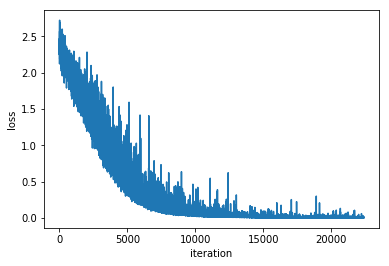

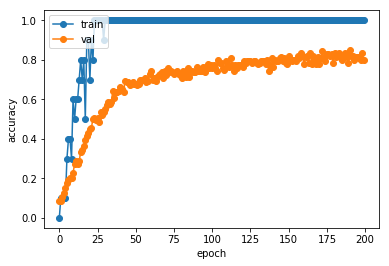

In [17]:
plt.plot(train_loss_history, '-')
#plt.plot(val_loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.show()

plt.plot(train_acc_history, '-o')
plt.plot(val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [18]:
for inputs, target in test_loader:
    inputs, targets = Variable(inputs), Variable(target)
    if torch.cuda.is_available():
        inputs, targets = inputs.cuda(), targets.cuda()

    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    _, target_indices = torch.max(targets, 1)
    scores.extend((preds == target_indices).data.cpu().numpy())

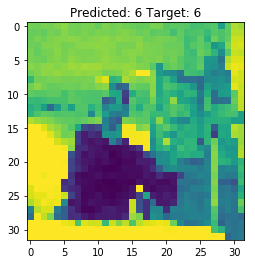

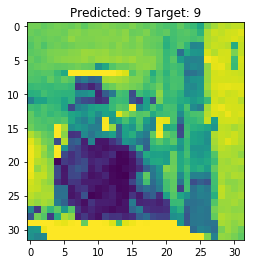

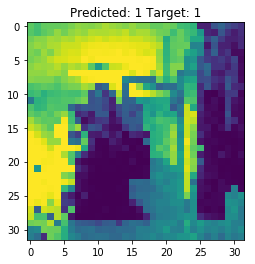

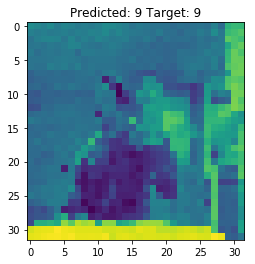

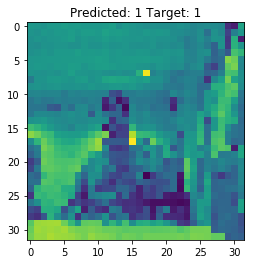

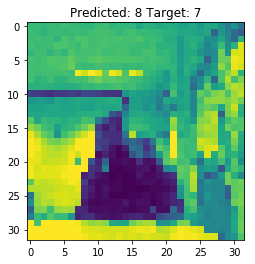

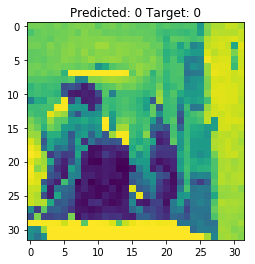

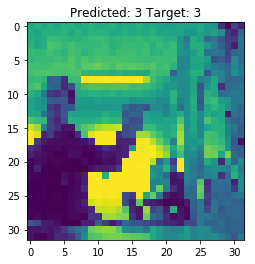

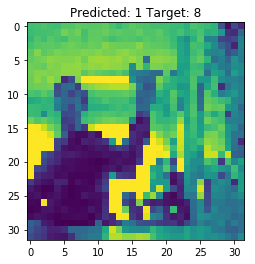

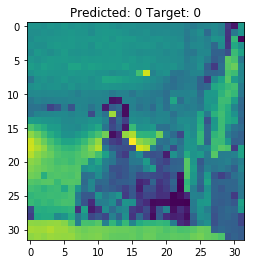

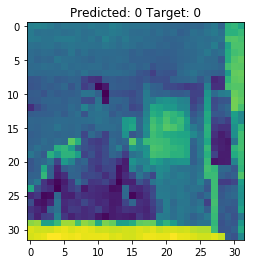

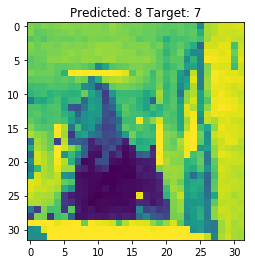

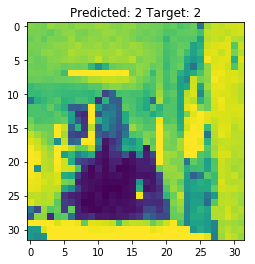

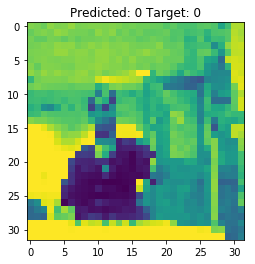

In [19]:
for inputs, target in test_loader:
    inputs, targets = Variable(inputs), Variable(target)
    if torch.cuda.is_available():
        inputs, targets = inputs.cuda(), targets.cuda()

    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    _, target_indices = torch.max(targets, 1)
    
    numpy_inputs = inputs.data.cpu().numpy()
    numpy_outputs = outputs.data.cpu().numpy()
    numpy_targets = targets.data.cpu().numpy()
    
    img = numpy_inputs[0]
    img = img[0, :, :]
    plt.imshow(img)
    plt.title("Predicted: "+str(preds[0].item()) + " Target: "+str(target_indices[0].item()))
    plt.show()
    #currentDT = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
    #path = "images/img_" + currentDT + ".png"
    #plt.imsave(path, img.astype(float))